## Deep Learning Approach To Anime Recommendation

Reference: https://www.kaggle.com/code/morrisb/how-to-recommend-anything-deep-recommender

In [1]:
# To store the data
import pandas as pd

# To do linear algebra
import numpy as np

# To create plots
import matplotlib.pyplot as plt

# To create interactive plots
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# To shift lists
from collections import deque

# To compute similarities between vectors
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer


# To create deep learning models
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.constraints import max_norm

# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline


UsageError: Line magic function `%` not found.


In [2]:
# Read data
anime = pd.read_csv('anime.csv')
synop = pd.read_csv('anime_with_synopsis.csv')
rating = pd.read_csv('rating_complete.csv')

In [4]:
# Select relevant columns
anime=anime[['MAL_ID', 'Name', 'Genres', 'English name',
       'Type', 'Rating']]

In [19]:
anime

MAL_ID                             Name  \
0           1                     Cowboy Bebop   
1           5  Cowboy Bebop: Tengoku no Tobira   
2           6                           Trigun   
3           7               Witch Hunter Robin   
4           8                   Bouken Ou Beet   
...       ...                              ...   
17557   48481  Daomu Biji Zhi Qinling Shen Shu   
17558   48483                     Mieruko-chan   
17559   48488  Higurashi no Naku Koro ni Sotsu   
17560   48491      Yama no Susume: Next Summit   
17561   48492                    Scarlet Nexus   

                                                  Genres  \
0        Action, Adventure, Comedy, Drama, Sci-Fi, Space   
1                  Action, Drama, Mystery, Sci-Fi, Space   
2      Action, Sci-Fi, Adventure, Comedy, Drama, Shounen   
3      Action, Mystery, Police, Supernatural, Drama, ...   
4              Adventure, Fantasy, Shounen, Supernatural   
...                                                  ...   
17557                   Adventure, Mystery, Supernatural   
17558                       Comedy, Horror, Supernatural   
17559  Mystery, Dementia, Horror, Psychological, Supe...   
17560                   Adventure, Slice of Life, Comedy   
17561                                    Action, Fantasy   

                          English name   Type                          Rating  
0                         Cowboy Bebop     TV  R - 17+ (violence & profanity)  
1               Cowboy Bebop:The Movie  Movie  R - 17+ (violence & profanity)  
2                               Trigun     TV       PG-13 - Teens 13 or older  
3                   Witch Hunter Robin     TV       PG-13 - Teens 13 or older  
4               Beet the Vandel Buster     TV                   PG - Children  
...                                ...    ...                             ...  
17557  Daomu Biji Zhi Qinling Shen Shu    ONA                         Unknown  
17558                     Mieruko-chan     TV                         Unknown  
17559  Higurashi:When They Cry – SOTSU     TV  R - 17+ (violence & profanity)  
17560      Yama no Susume: Next Summit     TV       PG-13 - Teens 13 or older  
17561                    Scarlet Nexus     TV                         Unknown  

[17562 rows x 6 columns]

In [5]:
# Select relevant columns
rating = rating[['user_id', 'anime_id', 'rating']]

In [25]:
rating.value_counts('anime_id')

anime_id
1535     182375
16498    169794
11757    161192
6547     141127
30276    138924
          ...  
35153         1
42465         1
42757         1
39627         1
40471         1
Length: 16872, dtype: int64

In [16]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57633278 entries, 0 to 57633277
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 1.3 GB


## EDA

In [10]:
test = rating.groupby('anime_id')['rating']

In [24]:
sum = rating.groupby('anime_id')['rating'].count()
mean = rating.groupby('anime_id')['rating'].mean()

In [27]:
sum.describe()

count     16872.000000
mean       3415.912636
std       10304.206874
min           1.000000
25%          40.000000
50%         266.000000
75%        1671.250000
max      182375.000000
Name: rating, dtype: float64

In [29]:
mean.describe()

count    16872.000000
mean         6.196639
std          1.118052
min          1.749910
25%          5.468604
50%          6.288750
75%          7.000000
max         10.000000
Name: rating, dtype: float64

In [29]:
rating.value_counts('user_id')

user_id
189037    15455
162615    14864
68042     13462
283786    12778
259790     9996
          ...  
201316        1
201300        1
97555         1
201293        1
137466        1
Length: 310059, dtype: int64

In [69]:
rating.user_id

0                0
1                0
2                0
3                0
4                0
             ...  
57633273    310058
57633274    310058
57633275    310058
57633276    310058
57633277    310058
Name: user_id, Length: 57633278, dtype: int64

### Ratings Per Animation & User Distribution Check

In [66]:
# Get data
data = rating.groupby('anime_id')['rating'].count().clip(upper=9999)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 10000,
                                  size = 100),
                     marker = dict(color = '#db0000'))
# Create layout
layout = go.Layout(title = 'Distribution Of Ratings Per Anime (Clipped at 9999)',
                   xaxis = dict(title = 'Ratings Per Anime'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


# Get data
data = rating.groupby('user_id')['rating'].count().clip(upper=300)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 300,
                                  size = 2),
                     marker = dict(color = '#db0000'))
# Create layout
layout = go.Layout(title = 'Distribution Of Ratings Per User (Clipped at 300)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

## Filter Sparse Animes 

In [6]:
# Filter sparse animes
min_anime_ratings = 100000
filter_animes = (rating['anime_id'].value_counts()>min_anime_ratings)
filter_animes = filter_animes[filter_animes].index.tolist()

# Filter sparse users
min_user_ratings = 300
filter_users = (rating['user_id'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

# Actual filtering
df_filterd = rating[(rating['anime_id'].isin(filter_animes)) & (rating['user_id'].isin(filter_users))]
del filter_animes, filter_users, min_anime_ratings, min_user_ratings
print('Shape User-Ratings unfiltered:\t{}'.format(rating.shape))
print('Shape User-Ratings filtered:\t{}'.format(df_filterd.shape))

Shape User-Ratings unfiltered:	(57633278, 3)
Shape User-Ratings filtered:	(1121815, 3)


In [10]:
df_filterd.head()

user_id  anime_id  rating
189        3     25835       8
190        3     28171       8
191        3     32282       8
192        3     35788       9
193        3      9253       9

## Prepare Train/Test

In [7]:
# Shuffle DataFrame
df_filterd = df_filterd.sample(frac=1).reset_index(drop=True)

# Testingsize ~20%
n = 224363

# Split train- & testset
df_train = df_filterd[:-n]
df_test = df_filterd[-n:]

In [8]:
print(len(df_train))
len(df_test)

897452


224363

In [9]:
# Create a user-anime matrix with empty values
df_p = df_train.pivot_table(index='user_id', columns='anime_id', values='rating')
print('Shape User-Anime-Matrix:\t{}'.format(df_p.shape))
df_p.sample(3)

Shape User-Anime-Matrix:	(56181, 28)


anime_id  20     199    226    1535   1575   2167   2904   4224   5114   \
user_id                                                                   
293176      NaN    NaN    NaN    8.0   10.0    NaN    9.0    NaN    9.0   
337298      7.0    9.0    7.0    9.0   10.0    NaN    NaN    9.0    NaN   
130671      9.0    9.0    NaN    8.0    7.0    9.0    NaN    NaN    NaN   

anime_id  6547   ...  19815  20507  21881  22319  25777  30276  31043  31240  \
user_id          ...                                                           
293176     10.0  ...    NaN    NaN    NaN    NaN    9.0    NaN    NaN    NaN   
337298      9.0  ...    9.0    8.0    NaN    7.0    9.0    9.0    8.0    9.0   
130671      NaN  ...   10.0    7.0    8.0    NaN    9.0    9.0   10.0   10.0   

anime_id  31964  32281  
user_id                 
293176      6.0    NaN  
337298      NaN    9.0  
130671      7.0    9.0  

[3 rows x 28 columns]

## DL Model 1

In [10]:
%%time 
# Create user & anime-id mapping
user_id_mapping = {id:i for i, id in enumerate(df_filterd['user_id'].unique())}
anime_id_mapping = {id:i for i, id in enumerate(df_filterd['anime_id'].unique())}

# Create correctly mapped train- & testset
train_user_data = df_train['user_id'].map(user_id_mapping)
train_anime_data = df_train['anime_id'].map(anime_id_mapping)

test_user_data = df_test['user_id'].map(user_id_mapping)
test_anime_data = df_test['anime_id'].map(anime_id_mapping)


# Get input variable-sizes
users = len(user_id_mapping)
animes = len(anime_id_mapping)
embedding_size = 10


##### Create model
# Set input layers
user_id_input = Input(shape=[1], name='user')
anime_id_input = Input(shape=[1], name='anime')

# Create embedding layers for users and animes
user_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)
anime_embedding = Embedding(output_dim=embedding_size, 
                            input_dim=animes,
                            input_length=1, 
                            name='item_embedding')(anime_id_input)

# Reshape the embedding layers
user_vector = Reshape([embedding_size])(user_embedding)
anime_vector = Reshape([embedding_size])(anime_embedding)

# Compute dot-product of reshaped embedding layers as prediction
y = Dot(1, normalize=False)([user_vector, anime_vector])

# Setup model
model = Model(inputs=[user_id_input, anime_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mape'])

# Fit model
history2 = model.fit([train_user_data, train_anime_data],
          df_train['rating'],
          batch_size=32, 
          epochs=15,
          validation_split=0.1,
          verbose = 1, 
          shuffle=True)

# Test model
y_pred = model.predict([test_user_data, test_anime_data])
y_true = df_test['rating'].values

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With Keras Matrix-Factorization: {:.4f} RMSE'.format(rmse))

Epoch 1/15
25241/25241 [==============================] - 112s 4ms/step - loss: 19.1849 - mse: 19.1849 - mape: 41.1415 - val_loss: 2.6208 - val_mse: 2.6208 - val_mape: 18.3656
Epoch 2/15
25241/25241 [==============================] - 126s 5ms/step - loss: 2.4235 - mse: 2.4235 - mape: 17.8676 - val_loss: 2.3552 - val_mse: 2.3552 - val_mape: 17.5170
Epoch 3/15
25241/25241 [==============================] - 112s 4ms/step - loss: 2.2420 - mse: 2.2420 - mape: 17.2657 - val_loss: 2.1901 - val_mse: 2.1901 - val_mape: 16.9994
Epoch 4/15
25241/25241 [==============================] - 106s 4ms/step - loss: 2.1155 - mse: 2.1155 - mape: 16.8164 - val_loss: 2.0900 - val_mse: 2.0900 - val_mape: 16.6339
Epoch 5/15
25241/25241 [==============================] - 128s 5ms/step - loss: 2.0266 - mse: 2.0266 - mape: 16.5040 - val_loss: 2.0092 - val_mse: 2.0092 - val_mape: 16.3685
Epoch 6/15
25241/25241 [==============================] - 127s 5ms/step - loss: 1.9475 - mse: 1.9475 - mape: 16.1979 - val_loss:

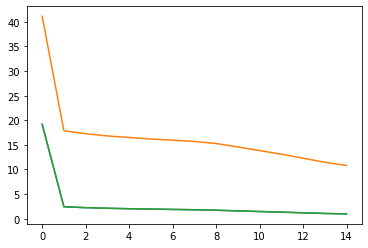

In [11]:
plt.plot(history2.history['mse'])
plt.plot(history2.history['mape'])
plt.plot(history2.history['loss'])
plt.show()

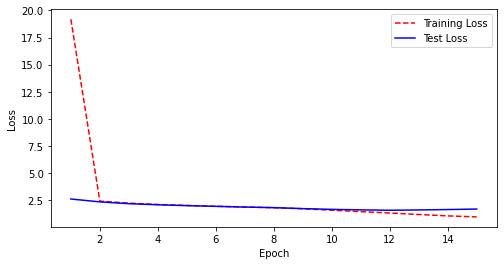

In [38]:
# Get training and test loss histories
training_loss = history2.history['loss']
test_loss = history2.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [53]:
# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression  (only for Keras tensors)
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 anime (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        561870      ['user[0][0]']                   
                                                                                                  
 item_embedding (Embedding)     (None, 1, 10)        280         ['anime[0][0]']                  
                                                                                              

In [13]:
model.save('model1')

INFO:tensorflow:Assets written to: model1\assets


In [14]:
print(train_user_data)
result = pd.DataFrame(test_user_data)
result = result.join(test_anime_data)
result['rating_prediction'] = y_pred
result['rating'] = y_true

0             0
1             1
2             2
3             3
4             4
          ...  
897447    22164
897448    10213
897449    35493
897450    32782
897451    34589
Name: user_id, Length: 897452, dtype: int64


In [15]:
result

user_id  anime_id  rating_prediction  rating
897452     15322        17           7.191785       8
897453      5525         4           9.055585       7
897454      7608        15           6.401648       7
897455     15274         2          10.792777      10
897456     29286        23           8.240267       8
...          ...       ...                ...     ...
1121810    33937        12           7.865749      10
1121811    45327        21           4.929711       6
1121812     9261        11           8.693233       9
1121813    12605        23           9.373533      10
1121814    36807         8           8.494165       8

[224363 rows x 4 columns]

In [16]:
result2 = pd.merge(result,synop,left_on='anime_id',right_on='MAL_ID')[['user_id','anime_id','rating_prediction','Name','Genres','sypnopsis']]

In [37]:
result2.head()

user_id  anime_id  rating_prediction                        Name  \
0    15322        17           7.191785  Hungry Heart: Wild Striker   
1    44826        17           7.857126  Hungry Heart: Wild Striker   
2    29275        17           7.074538  Hungry Heart: Wild Striker   
3     7504        17           7.854937  Hungry Heart: Wild Striker   
4    55656        17           9.448362  Hungry Heart: Wild Striker   

                                   Genres  \
0  Slice of Life, Comedy, Sports, Shounen   
1  Slice of Life, Comedy, Sports, Shounen   
2  Slice of Life, Comedy, Sports, Shounen   
3  Slice of Life, Comedy, Sports, Shounen   
4  Slice of Life, Comedy, Sports, Shounen   

                                           sypnopsis  
0  Kyosuke Kano has lived under the shadow of his...  
1  Kyosuke Kano has lived under the shadow of his...  
2  Kyosuke Kano has lived under the shadow of his...  
3  Kyosuke Kano has lived under the shadow of his...  
4  Kyosuke Kano has lived under the shadow of his...

In [35]:
test = result2.query('user_id==38425 & rating_prediction>7.0')

In [99]:
test[['Name', 'Genres','sypnopsis']]

Name                                     Genres  \
48      Hungry Heart: Wild Striker     Slice of Life, Comedy, Sports, Shounen   
98984                School Rumble           Comedy, Romance, School, Shounen   
110556         Tennis no Ouji-sama    Action, Comedy, Sports, School, Shounen   
123568              Bouken Ou Beet  Adventure, Fantasy, Shounen, Supernatural   
136670               Trinity Blood              Action, Supernatural, Vampire   

                                                sypnopsis  
48      Kyosuke Kano has lived under the shadow of his...  
98984   Just the words "I love you," and everything ch...  
110556  The world of tennis is harsh and highly compet...  
123568  It is the dark century and the people are suff...  
136670  Following Armageddon, an apocalyptic war, mank...

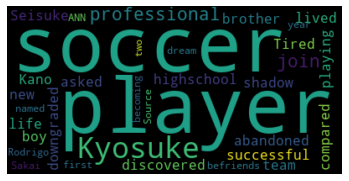

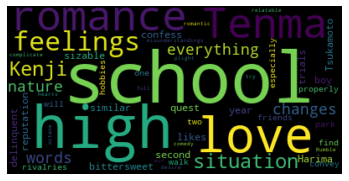

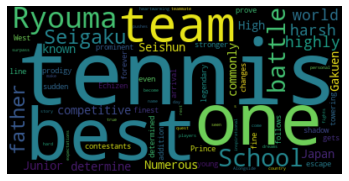

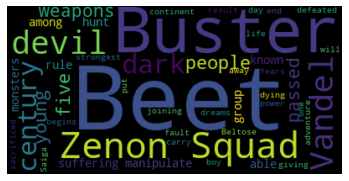

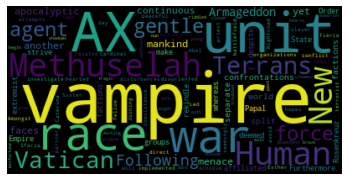

In [36]:
for i in test.sypnopsis:
    wordcloud = WordCloud().generate(i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## DL Model 2

In [120]:
%%time
# Create user & anime-id mapping
user_id_mapping = {id:i for i, id in enumerate(df_filterd['user_id'].unique())}
anime_id_mapping = {id:i for i, id in enumerate(df_filterd['anime_id'].unique())}

# Create correctly mapped train- & testset
train_user_data = df_train['user_id'].map(user_id_mapping)
train_anime_data = df_train['anime_id'].map(anime_id_mapping)

test_user_data = df_test['user_id'].map(user_id_mapping)
test_anime_data = df_test['anime_id'].map(anime_id_mapping)


# Get input variable-sizes
users = len(user_id_mapping)
animes = len(anime_id_mapping)
embedding_size = 10

# Setup variables
user_embedding_size = 20
anime_embedding_size = 10

##### Create model
# Set input layers
user_id_input = Input(shape=[1], name='user')
anime_id_input = Input(shape=[1], name='anime')

# Create embedding layers for users and animes
user_embedding = Embedding(output_dim=user_embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)
anime_embedding = Embedding(output_dim=anime_embedding_size, 
                            input_dim=animes,
                            input_length=1, 
                            name='item_embedding')(anime_id_input)

# Reshape the embedding layers
user_vector = Reshape([user_embedding_size])(user_embedding)
anime_vector = Reshape([anime_embedding_size])(anime_embedding)

# Concatenate the reshaped embedding layers
concat = Concatenate()([user_vector, anime_vector])

# Combine with dense layers
dense = Dense(256)(concat)
# Added dropout as it was overfitting (VAL LOSS increases while TRAIN LOSS decreases)
dense = Dropout(0.2)(dense)

y = Dense(1, name = 'prediction')(dense)

# Setup model

model = Model(inputs=[user_id_input, anime_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam',  metrics=['mse', 'mape'])

# Fit model
history = model.fit([train_user_data, train_anime_data],
          df_train['rating'],
          batch_size=256, 
          epochs=15,
          validation_split=0.1,
          shuffle=True, 
          verbose = 1)

# Test model
y_pred = model.predict([test_user_data, test_anime_data])
y_true = df_test['rating'].values

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With Keras Deep Learning: {:.4f} RMSE'.format(rmse))

Epoch 1/15
3156/3156 [==============================] - 34s 11ms/step - loss: 2.7446 - mse: 2.7446 - mape: 17.7301 - val_loss: 1.5555 - val_mse: 1.5555 - val_mape: 15.1445
Epoch 2/15
3156/3156 [==============================] - 32s 10ms/step - loss: 1.5413 - mse: 1.5413 - mape: 14.9261 - val_loss: 1.5022 - val_mse: 1.5022 - val_mape: 14.7912
Epoch 3/15
3156/3156 [==============================] - 34s 11ms/step - loss: 1.4956 - mse: 1.4956 - mape: 14.6203 - val_loss: 1.4974 - val_mse: 1.4974 - val_mape: 14.9226
Epoch 4/15
3156/3156 [==============================] - 34s 11ms/step - loss: 1.4691 - mse: 1.4691 - mape: 14.4552 - val_loss: 1.4856 - val_mse: 1.4856 - val_mape: 14.8173
Epoch 5/15
3156/3156 [==============================] - 35s 11ms/step - loss: 1.4501 - mse: 1.4501 - mape: 14.3357 - val_loss: 1.4812 - val_mse: 1.4812 - val_mape: 14.6489
Epoch 6/15
3156/3156 [==============================] - 35s 11ms/step - loss: 1.4346 - mse: 1.4346 - mape: 14.2418 - val_loss: 1.4778 - val_

MAPE < 20% is Good)

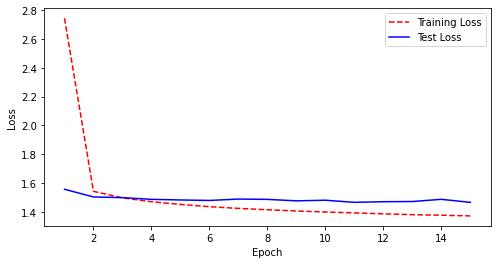

In [121]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

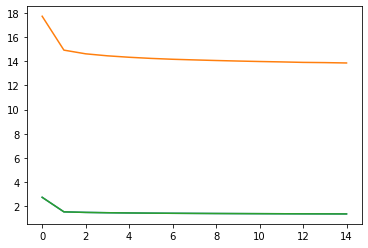

In [122]:
plt.plot(history.history['mse'])
plt.plot(history.history['mape'])
plt.plot(history.history['loss'])
plt.show()

In [123]:
model.summary() 

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 anime (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 20)        1123740     ['user[0][0]']                   
                                                                                                  
 item_embedding (Embedding)     (None, 1, 10)        280         ['anime[0][0]']                  
                                                                                           

In [124]:
print(train_user_data)
result = pd.DataFrame(test_user_data)
result = result.join(test_anime_data)
result['rating_prediction'] = y_pred
result['rating'] = y_true

0             0
1             1
2             2
3             3
4             4
          ...  
897447     1071
897448     7415
897449    17911
897450     4181
897451    14803
Name: user_id, Length: 897452, dtype: int64


In [125]:
result 

user_id  anime_id  rating_prediction  rating
897452      9954         3           7.126274       8
897453     37791         4           9.329976      10
897454     50374        12           8.568424      10
897455     27964        18          10.376443      10
897456     12860        18           6.829157       3
...          ...       ...                ...     ...
1121810    43743         7           7.806363       8
1121811    16548        18           8.489704       8
1121812    21252         5           9.007524      10
1121813    50064        11           7.543243       8
1121814     9607         1           6.718158       9

[224363 rows x 4 columns]

### Sample of Result 
Users may rate Slayers Return ratings.

In [126]:
result2 = pd.merge(result,synop,left_on='anime_id',right_on='MAL_ID')[['user_id','anime_id','rating_prediction','Name','Genres','sypnopsis']]

#### For a user_id 46057, based on previous rating history, the recommendation would be as following.

In [103]:
result2.query('user_id==46057').sort_values(by='rating_prediction', ascending=False)[['Name','Genres','sypnopsis']]

Name                                        Genres  \
93625  Hachimitsu to Clover  Comedy, Drama, Josei, Romance, Slice of Life   

                                               sypnopsis  
93625  Yuuta Takemoto, a sophomore at an arts college...

In [128]:
test_result = result2.query('user_id==46057').sort_values(by='rating_prediction', ascending=False)

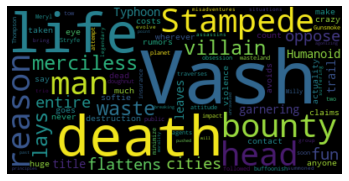

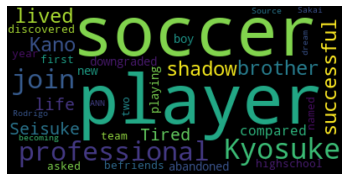

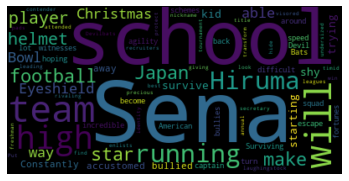

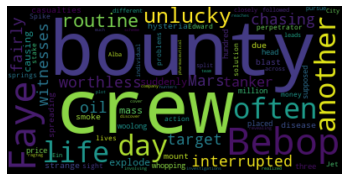

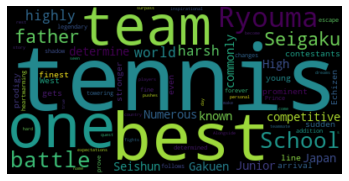

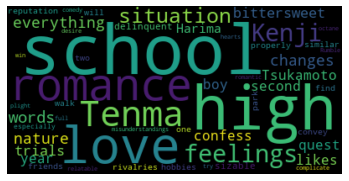

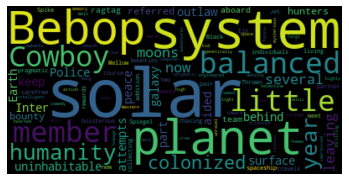

In [129]:
for i in test_result.sypnopsis:
    wordcloud = WordCloud().generate(i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [102]:
result2.query('user_id==46057').sort_values(by='rating_prediction', ascending=False)[['Name', 'Genres','sypnopsis']]

Name                                        Genres  \
93625  Hachimitsu to Clover  Comedy, Drama, Josei, Romance, Slice of Life   

                                               sypnopsis  
93625  Yuuta Takemoto, a sophomore at an arts college...

In [3]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


array([[<AxesSubplot:title={'center':'rating_prediction'}>]], dtype=object)

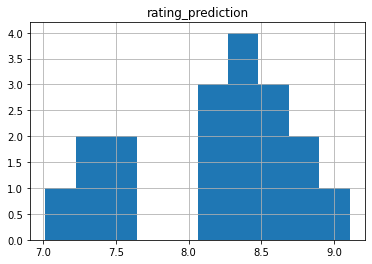

In [130]:
result2[['Name','rating_prediction']].groupby('Name').mean('rating_prediction').hist()

In [131]:
model.save('model2')

INFO:tensorflow:Assets written to: model2\assets


In [39]:
synop

MAL_ID                             Name    Score  \
0           1                     Cowboy Bebop     8.78   
1           5  Cowboy Bebop: Tengoku no Tobira     8.39   
2           6                           Trigun     8.24   
3           7               Witch Hunter Robin     7.27   
4           8                   Bouken Ou Beet     6.98   
...       ...                              ...      ...   
16209   48481  Daomu Biji Zhi Qinling Shen Shu  Unknown   
16210   48483                     Mieruko-chan  Unknown   
16211   48488  Higurashi no Naku Koro ni Sotsu  Unknown   
16212   48491      Yama no Susume: Next Summit  Unknown   
16213   48492                    Scarlet Nexus  Unknown   

                                                  Genres  \
0        Action, Adventure, Comedy, Drama, Sci-Fi, Space   
1                  Action, Drama, Mystery, Sci-Fi, Space   
2      Action, Sci-Fi, Adventure, Comedy, Drama, Shounen   
3      Action, Mystery, Police, Supernatural, Drama, ...   
4              Adventure, Fantasy, Shounen, Supernatural   
...                                                  ...   
16209                   Adventure, Mystery, Supernatural   
16210                       Comedy, Horror, Supernatural   
16211  Mystery, Dementia, Horror, Psychological, Supe...   
16212                   Adventure, Slice of Life, Comedy   
16213                                    Action, Fantasy   

                                               sypnopsis  
0      In the year 2071, humanity has colonized sever...  
1      other day, another bounty—such is the life of ...  
2      Vash the Stampede is the man with a $$60,000,0...  
3      ches are individuals with special powers like ...  
4      It is the dark century and the people are suff...  
...                                                  ...  
16209  No synopsis information has been added to this...  
16210  ko is a typical high school student whose life...  
16211          Sequel to Higurashi no Naku Koro ni Gou .  
16212                          New Yama no Susume anime.  
16213  Solar calendar year 2020: grotesque organisms ...  

[16214 rows x 5 columns]

In [40]:
synop.isnull().sum()

MAL_ID       0
Name         0
Score        0
Genres       0
sypnopsis    8
dtype: int64

In [41]:
# Fill null values for synopsis column with ' '
synop.sypnopsis.fillna(' ', inplace = True)

In [42]:
synop['combined'] = synop[['Name', 'sypnopsis']].agg(' '.join, axis= 1)

In [43]:
synop.combined

0        Cowboy Bebop In the year 2071, humanity has co...
1        Cowboy Bebop: Tengoku no Tobira other day, ano...
2        Trigun Vash the Stampede is the man with a $$6...
3        Witch Hunter Robin ches are individuals with s...
4        Bouken Ou Beet It is the dark century and the ...
                               ...                        
16209    Daomu Biji Zhi Qinling Shen Shu No synopsis in...
16210    Mieruko-chan ko is a typical high school stude...
16211    Higurashi no Naku Koro ni Sotsu Sequel to Higu...
16212    Yama no Susume: Next Summit New Yama no Susume...
16213    Scarlet Nexus Solar calendar year 2020: grotes...
Name: combined, Length: 16214, dtype: object

In [44]:
import nltk
import regex as re

In [45]:
stop_words = nltk.corpus.stopwords.words('english')

#Basic Data Cleaning
synop['clean_sentences'] = synop['combined'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
synop['clean_sentences'] = synop['clean_sentences'].apply(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', '', x))
synop['clean_sentences'] = synop['clean_sentences'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))
synop['clean_sentences'] = synop['clean_sentences'].apply(lambda x: ' '.join([word for word in x.split() if not word.isnumeric()]))
synop['clean_sentences'] = synop['clean_sentences'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
synop['clean_sentences'] = synop['clean_sentences'].apply(lambda x: ' '.join([word.lower() for word in x.split()]))

synop_df = synop[['clean_sentences']]

In [46]:
synop_df

clean_sentences
0      cowboy bebop in year humanity colonized severa...
1      cowboy tengoku tobira another bountysuch life ...
2      trigun vash stampede man bounty the hes mercil...
3      witch hunter robin ches individuals special po...
4      bouken ou beet it dark century people sufferin...
...                                                  ...
16209  daomu biji zhi qinling shen shu no synopsis in...
16210  mierukochan ko typical high school student who...
16211  higurashi naku koro ni sotsu sequel higurashi ...
16212                   yama next summit new yama susume
16213  scarlet nexus solar calendar year grotesque or...

[16214 rows x 1 columns]

In [47]:
sentences = [row.split() for row in synop_df['clean_sentences']]
sentences[:1]

[['cowboy',
  'bebop',
  'in',
  'year',
  'humanity',
  'colonized',
  'several',
  'planets',
  'moons',
  'solar',
  'system',
  'leaving',
  'uninhabitable',
  'surface',
  'planet',
  'earth',
  'the',
  'inter',
  'solar',
  'system',
  'police',
  'attempts',
  'keep',
  'peace',
  'aided',
  'part',
  'outlaw',
  'bounty',
  'referred',
  'the',
  'ragtag',
  'team',
  'aboard',
  'spaceship',
  'bebop',
  'two',
  'mellow',
  'carefree',
  'spike',
  'spiegel',
  'balanced',
  'pragmatic',
  'partner',
  'jet',
  'black',
  'pair',
  'makes',
  'living',
  'chasing',
  'bounties',
  'collecting',
  'thrown',
  'course',
  'addition',
  'new',
  'members',
  'meet',
  'genetically',
  'highly',
  'intelligent',
  'welsh',
  'corgi',
  'femme',
  'fatale',
  'faye',
  'enigmatic',
  'trickster',
  'memory',
  'loss',
  'strange',
  'computer',
  'whiz',
  'kid',
  'edward',
  'wongthe',
  'crew',
  'embarks',
  'thrilling',
  'adventures',
  'unravel',
  'members',
  'dark',
  '

In [49]:
synop

MAL_ID                             Name    Score  \
0           1                     Cowboy Bebop     8.78   
1           5  Cowboy Bebop: Tengoku no Tobira     8.39   
2           6                           Trigun     8.24   
3           7               Witch Hunter Robin     7.27   
4           8                   Bouken Ou Beet     6.98   
...       ...                              ...      ...   
16209   48481  Daomu Biji Zhi Qinling Shen Shu  Unknown   
16210   48483                     Mieruko-chan  Unknown   
16211   48488  Higurashi no Naku Koro ni Sotsu  Unknown   
16212   48491      Yama no Susume: Next Summit  Unknown   
16213   48492                    Scarlet Nexus  Unknown   

                                                  Genres  \
0        Action, Adventure, Comedy, Drama, Sci-Fi, Space   
1                  Action, Drama, Mystery, Sci-Fi, Space   
2      Action, Sci-Fi, Adventure, Comedy, Drama, Shounen   
3      Action, Mystery, Police, Supernatural, Drama, ...   
4              Adventure, Fantasy, Shounen, Supernatural   
...                                                  ...   
16209                   Adventure, Mystery, Supernatural   
16210                       Comedy, Horror, Supernatural   
16211  Mystery, Dementia, Horror, Psychological, Supe...   
16212                   Adventure, Slice of Life, Comedy   
16213                                    Action, Fantasy   

                                               sypnopsis  \
0      In the year 2071, humanity has colonized sever...   
1      other day, another bounty—such is the life of ...   
2      Vash the Stampede is the man with a $$60,000,0...   
3      ches are individuals with special powers like ...   
4      It is the dark century and the people are suff...   
...                                                  ...   
16209  No synopsis information has been added to this...   
16210  ko is a typical high school student whose life...   
16211          Sequel to Higurashi no Naku Koro ni Gou .   
16212                          New Yama no Susume anime.   
16213  Solar calendar year 2020: grotesque organisms ...   

                                                combined  \
0      Cowboy Bebop In the year 2071, humanity has co...   
1      Cowboy Bebop: Tengoku no Tobira other day, ano...   
2      Trigun Vash the Stampede is the man with a $$6...   
3      Witch Hunter Robin ches are individuals with s...   
4      Bouken Ou Beet It is the dark century and the ...   
...                                                  ...   
16209  Daomu Biji Zhi Qinling Shen Shu No synopsis in...   
16210  Mieruko-chan ko is a typical high school stude...   
16211  Higurashi no Naku Koro ni Sotsu Sequel to Higu...   
16212  Yama no Susume: Next Summit New Yama no Susume...   
16213  Scarlet Nexus Solar calendar year 2020: grotes...   

                                         clean_sentences  
0      cowboy bebop in year humanity colonized severa...  
1      cowboy tengoku tobira another bountysuch life ...  
2      trigun vash stampede man bounty the hes mercil...  
3      witch hunter robin ches individuals special po...  
4      bouken ou beet it dark century people sufferin...  
...                                                  ...  
16209  daomu biji zhi qinling shen shu no synopsis in...  
16210  mierukochan ko typical high school student who...  
16211  higurashi naku koro ni sotsu sequel higurashi ...  
16212                   yama next summit new yama susume  
16213  scarlet nexus solar calendar year grotesque or...  

[16214 rows x 7 columns]